<a href="https://colab.research.google.com/github/Imartinezcuevas/k_brazos_MC_OL/blob/main/bandit_experiment_UCB2vsGPreferencias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo UCB2 vs Gradiente de Preferencias en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de los algoritmos UCB2 y Gradiente de Preferencias en un problema de k-armed bandit.

    Author: Iván Martínez Cuevas y Antonio Orenes Lucas
    Email: ivan.martinezc@um.es y antonio.orenesl@um.es
    Date: 2025/02/12

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html

# Introducción
En este estudio, nos enfocamos en comparar el rendimiento de UCB2 y Gradiente de Preferencias, dos algoritmos que han mostrado resultados significativos dentro de sus respectivas familias. UCB2, una versión optimizada de UCB1, ha demostrado un mejor desempeño en distintas distribuciones y con diferentes cantidades de brazos. Por otro lado, el algoritmo de Gradiente de Preferencias supera a la estrategia Softmax dentro de la familia de Ascenso del Gradiente. Si visitamos el notebook donde se hace la comparación, se observa que Softmax ni siquiera llega a la recompensa óptima.

El objetivo principal de este estudio es analizar y comparar el rendimiento de estos dos algoritmos bajo diversas condiciones experimentales. Para ello, se evaluará su desempeño mediante:

1. **Estudio individual de cada algoritmo**: Se analizará el impacto de la variación de parámetros clave, como la tasa de aprendizaje (α) en Gradiente de Preferencias y el parámetro de exploración en UCB2.

*Como ya hemos hecho el estudio individual en cada notebook correspondiente, pasaremos directamente al paso 2 con los parámetros que muestran mejores resultados.*

2. **Comparación directa entre UCB2 y Gradiente de Preferencias**: Se seleccionarán los mejores parámetros de cada algoritmo y se comparará su rendimiento en entornos controlados.
3. **Estudio de la influencia de las distribuciones de recompensa**: Se modificarán las distribuciones subyacentes para analizar la robustez de cada enfoque.
4. **Evaluación con diferentes cantidades de brazos**: Se estudiará el efecto de aumentar o disminuir el número de brazos en la efectividad de cada algoritmo.

A través de estos experimentos, buscamos entender en qué escenarios cada algoritmo sobresale y proporcionar recomendaciones sobre su aplicabilidad en problemas reales de toma de decisiones secuenciales.

## Preparación del entorno

In [1]:
#@title Copiar el repositorio.

!git clone https://github.com/Imartinezcuevas/k_brazos_MC_OL.git
!cd k_brazos_MC_OL/

Cloning into 'k_brazos_MC_OL'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 227 (delta 120), reused 130 (delta 53), pack-reused 0 (from 0)
Receiving objects: 100% (227/227), 21.25 MiB | 11.18 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [2]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_MC_OL/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, UCB2, GradientePreferencias
from arms import ArmNormal, Bandit, ArmBernoulli, ArmBinomial
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret, plot_arm_statistics

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_MC_OL/src']


## Bucle experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [3]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    regrets = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret acumulado.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    # Para almacenar selecciones y recompensas promedio de cada brazo por algoritmo
    arm_counts = np.zeros((len(algorithms), bandit.k))  # Número de selecciones por brazo
    arm_rewards = np.zeros((len(algorithms), bandit.k))  # Suma de recompensas por brazo

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)
        # Obtener la recompensa esperada óptima.
        optimal_reward = current_bandit.get_expected_value(optimal_arm)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.
                regrets[idx, step] = optimal_reward*(step+1) - total_rewards_per_algo[idx] # Acumular el regret en la matriz regrets para el algoritmo idx en el paso step.


                #TODO: modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm",
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Registrar número de selecciones y recompensas por brazo
                arm_counts[idx, chosen_arm] += 1
                arm_rewards[idx, chosen_arm] += reward


    rewards /= runs
    regrets /= runs  # Calcular el promedio del regret acumulado
    arm_avg_rewards = np.divide(arm_rewards, arm_counts, out=np.zeros_like(arm_rewards), where=arm_counts != 0)
    # TODO: calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje

    return rewards, optimal_selections, regrets, arm_counts, arm_avg_rewards

# Análisis comparativo

### Comparación entre algoritmos
Las variantes a estudiar son las siguiente:
* Para Gradiente de Preferencias: alpha = {0.1, 0.3}
* Para UCB2:
  * Vimos que para distribución normal funciona mejor alpha = 1 y, para distribucion binomial y de Bernoulli funciona mejor alphas bajos. Vamos a probar 0.5 y 0.25.

Cosas a estudiar:
* Velocidad de convergencia de cada algoritmo.
* Comparar la recompensa acumulada y regret alcanzados por cada uno.
* Observar la capacidad de cada algoritmo para identificar y seleccionar el brazo óptimo.

In [4]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=1), GradientePreferencias(k=k, alpha=0.1), GradientePreferencias(k=k, alpha=0.3)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


#### Recompensa promedio

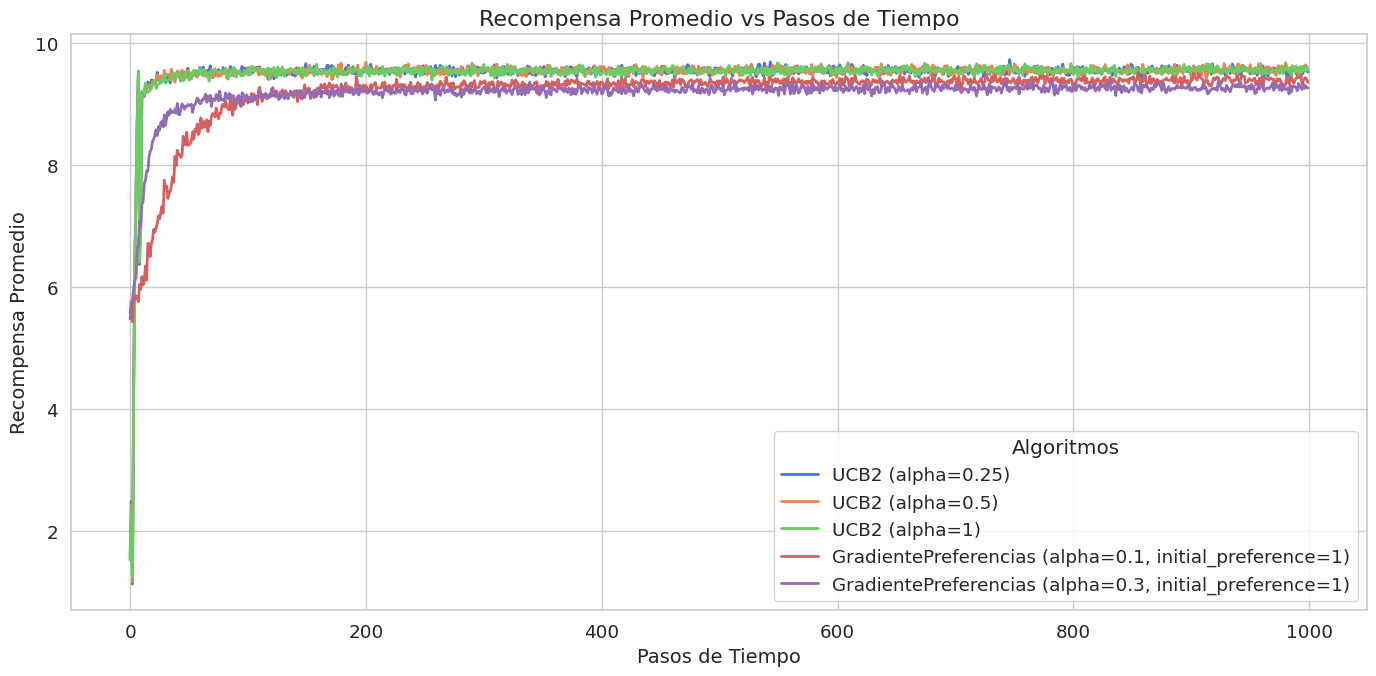

In [5]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos UCB2 y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
1. **UCB2 (α = 0.25, 0.5, 1):**

  * Estas curvas (en azul, naranja y verde) tienden a converger a una recompensa promedio cercana a 9.50 con pequeñas fluctuaciones..

2. **Gradiente de Preferencias (α = 0.1 y α = 0.3):**

  * La línea morada (α=0.3) alcanza rápidamente una recompensa alta, similar a UCB2.
  * La línea roja (α=0.1) muestra un crecimiento bastante más lento.

**Conclusiones**
  * UCB2 tiene un buen desempeño, alcanzando rápidamente recompensas altas.
  * El método de Gradiente de Preferencias con α=0.1 es más lento en aprender.
  * Todos los algoritmos convergen hacia una recompensa promedio alta, pero algunos tardan más en llegar.

#### Regret acumulado

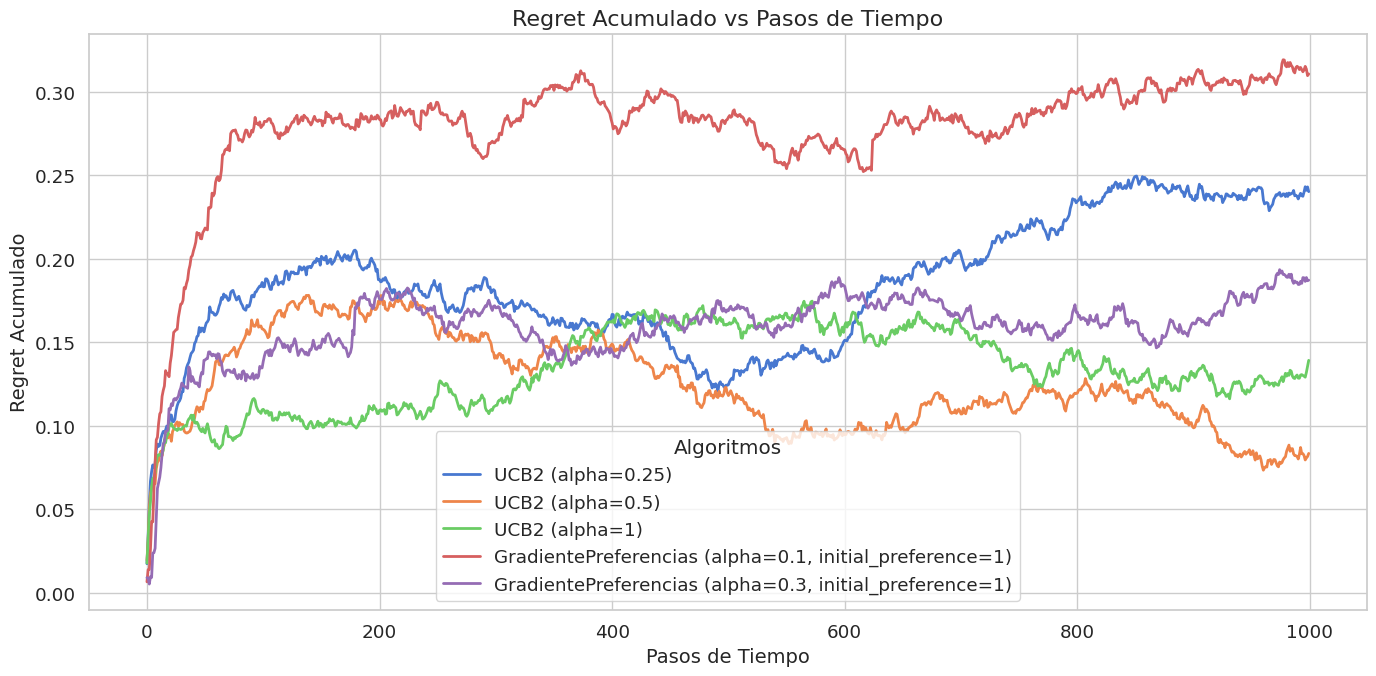

In [6]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos UCB2 y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
  * Todos las variantes de UCB2 obtienen un resultado muy bueno. Siendo la mejor la que tiene alpha=0.25, aunque puede deberse a la varianza.
  * El rendimiento de la variante de Gradiente de Preferencias con alpha=0.3 es, también, bastante bueno

**Conclusiones**
  * El mejor algoritmo es UCB2 en cuanto al regret acumulado.

#### Porcentaje de selección del brazo óptimo

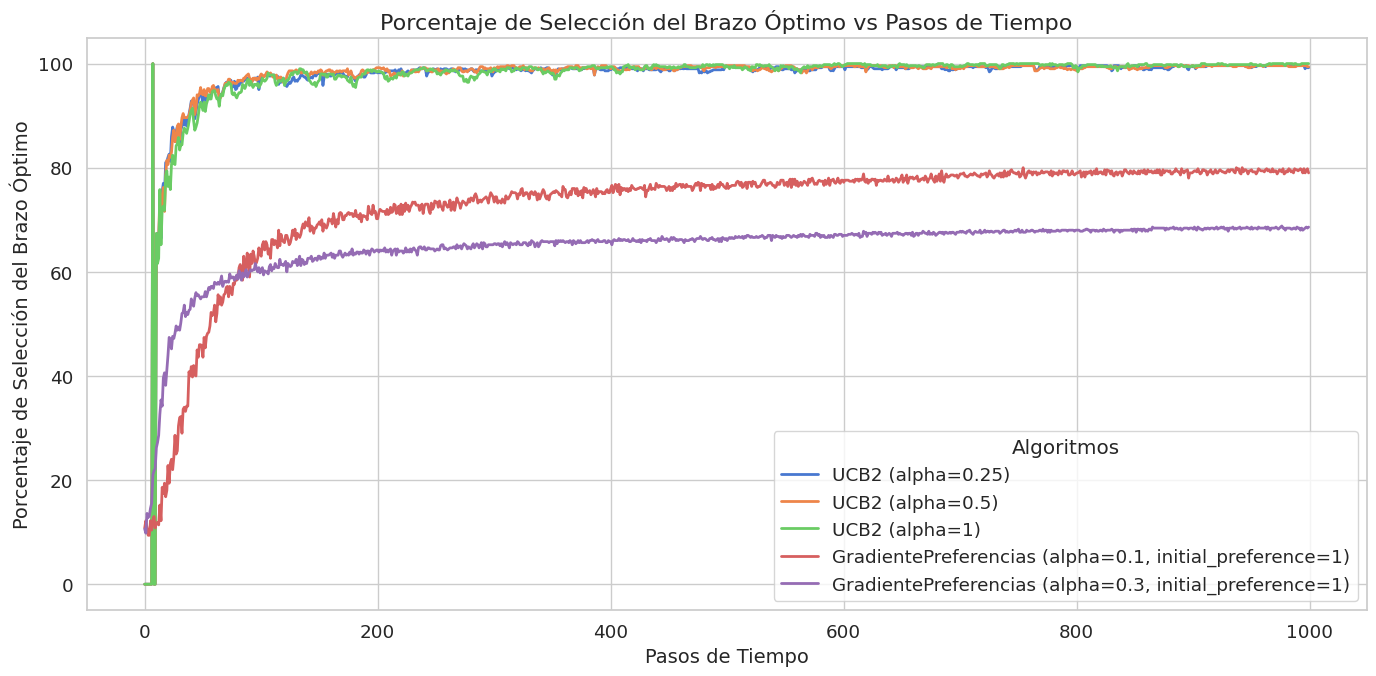

In [7]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos UCB2 y Gradiente de Preferencias con diferentes valores de parámetros.

**Observaciones principales**
1. **UCB2 (α = 0.25, 0.5, 1) - Líneas Azul, Naranja y Verde:**

  * Desde las primeras iteraciones, estos algoritmos aprenden rápidamente a seleccionar el brazo óptimo.
  * Después de aproximadamente 200 iteraciones, todas las variantes de UCB2 alcanzan casi 100% de selección del brazo óptimo y se mantienen estables.
  * No hay diferencias significativas entre los valores de α en términos de selección del mejor brazo o, por lo menos, no se puede apreciar.

2. **Gradiente de Preferencias (α=0.1 y α=0.3) - Líneas Roja y Morada:**

  * Gradiente de Preferencias con α=0.1 (Roja):
    * Aprende más rápido que α=0.1, pero su selección del brazo óptimo se estabiliza alrededor del 80%, sin alcanzar el 100%.
  * Gradiente de Preferencias con α=0.3 (Morado):
    * Aprende más lentamente que todas las demás estrategias.
    * Después de 2000 pasos de tiempo, apenas llega al 70% de selección del brazo óptimo, con más variabilidad en su desempeño.

**Conclusiones**
* UCB2 es la mejor estrategia para seleccionar consistentemente el brazo óptimo.
* Gradiente de Preferencias con α=0.1 tiene un desempeño aceptable, pero no alcanza el 100% de selección del mejor brazo.
* Gradiente de Preferencias con α=0.3 es el algoritmo con peor rendimiento, ya que tarda mucho en aprender.

## Comparación entre número de brazos
Para comparar los algoritmos en escenarios con diferentes niveles de complejidad. Para ello en este apartado se estudiará como el número de brazos afecta en la capacidad de convergencia y la eficiencia de ambos algoritmos.

Los objetivos son:
* Determinar como el rendimiento de los algoritmos se ve afectado al aumentar el número de brazos.
* Observar como la velocidad de convergencia varía en función del número de brazos.

Se realizarán experimentos variando el número de brazos en el siguiente rango $[10, 30]$.

#### K = 20

In [8]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 20  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=1), GradientePreferencias(k=k, alpha=0.1), GradientePreferencias(k=k, alpha=0.3)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 20 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=2.91, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0), ArmNormal(mu=9.73, sigma=1.0), ArmNormal(mu=8.49, sigma=1.0), ArmNormal(mu=5.72, sigma=1.0), ArmNormal(mu=6.51, sigma=1.0), ArmNormal(mu=3.74, sigma=1.0), ArmNormal(mu=3.62, sigma=1.0), ArmNormal(mu=4.89, sigma=1.0), ArmNormal(mu=2.64, sigma=1.0), ArmNormal(mu=2.65, sigma=1.0)
Optimal arm: 12 with expected reward=9.73


##### Recompensa promedio

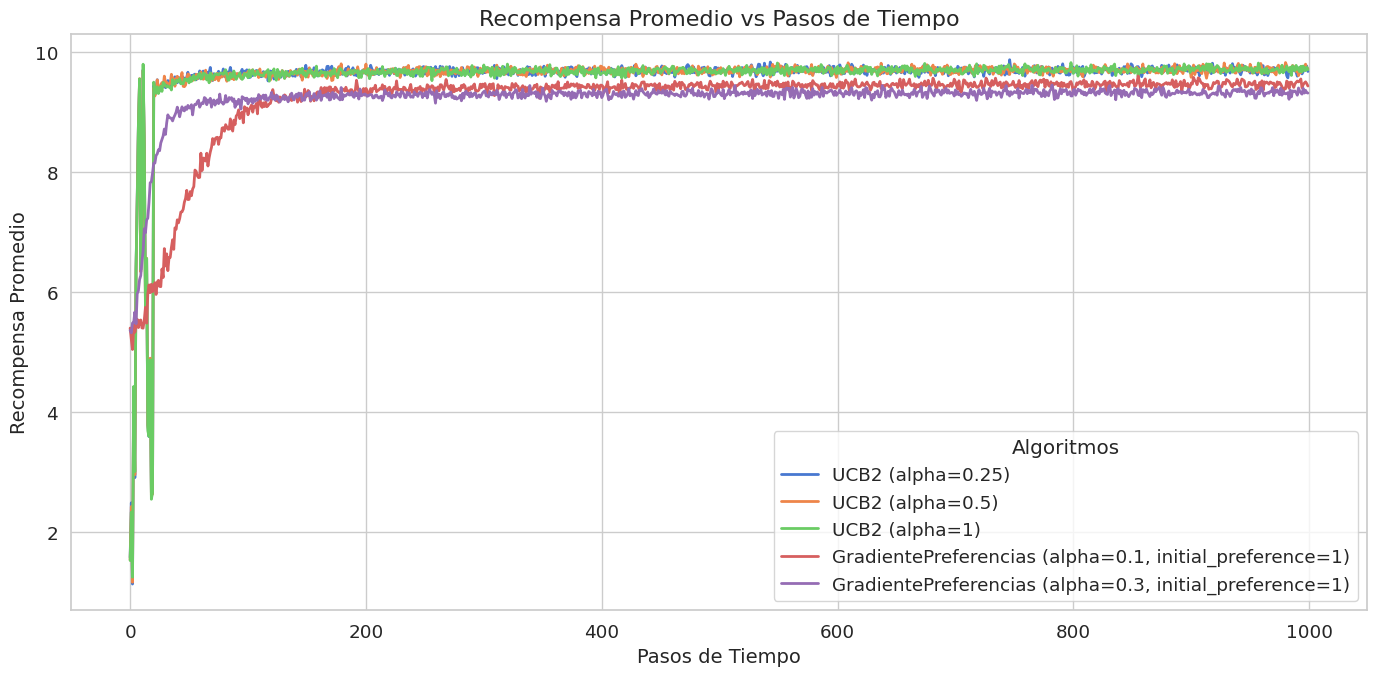

In [9]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos UCB2 y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
1. **UCB2 (α = 0.25, 0.5, 1):**

  * Todas las variantes de UCB2 alcanzan rápidamente una recompensa promedio cercana a 10.
  * Aumenta la longitud de la fase exploratoria. Introduciendo errores al inicio que hagan que el porcentaje de seleccion disminuya y el regret aumente.

2. **Gradiente de Preferencias (α = 0.01 y α = 0.1):**

  * La línea roja (α=0.1) aprende más lento que la variante con α=0.3, alcanzando una recompensa promedio cercana a 9.5, algo inferior a la óptima.
  * La línea morada (α=0.3) muestra un crecimiento más rápido.
  * Al final de la simulación, aún no ha alcanzado el nivel de las otras estrategias.

**Conclusiones**
  * UCB2 es la mejor estrategia en términos de recompensa promedio, alcanzando rápidamente valores cercanos a 10.
  * Gradiente de Preferencias con α=0.3 tiene un desempeño decente, pero inferior a UCB2.
  * Aumentar el número de brazo no parece perjudicar a los algoritmos.

##### Regret acumulado

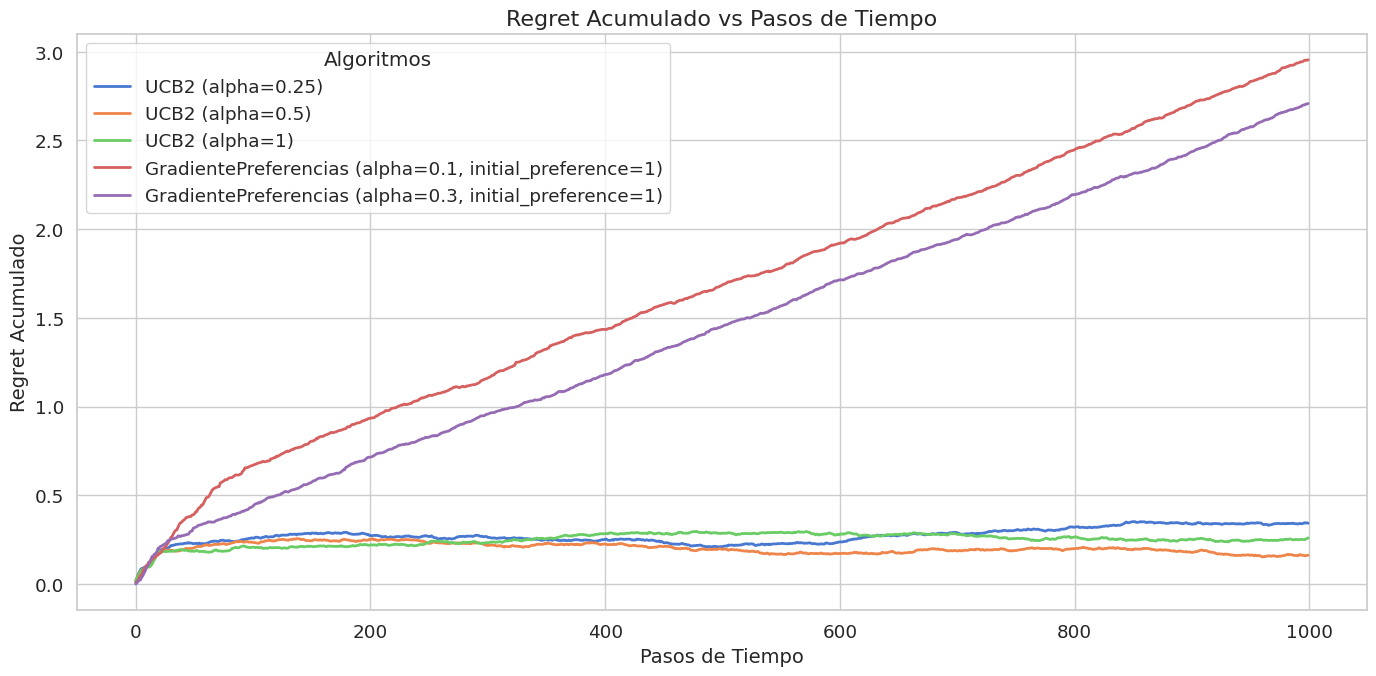

In [10]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos UCB2 y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
  * Todos las variantes de UCB2 obtienen un resultado muy bueno.
  * El rendimiento de la variante de Gradiente de Preferencias con alpha=0.1 es, también, bastante bueno
  * La pero es la variante de Gradiente de Preferecias con alpha=0.3 que siempre sube. Posiblemente a que haya seleccionado un brazo subóptimo.

**Conclusiones**
  * El mejor algoritmo es UCB2 en cuanto al regret acumulado.

##### Porcentaje de selección del brazo óptimo

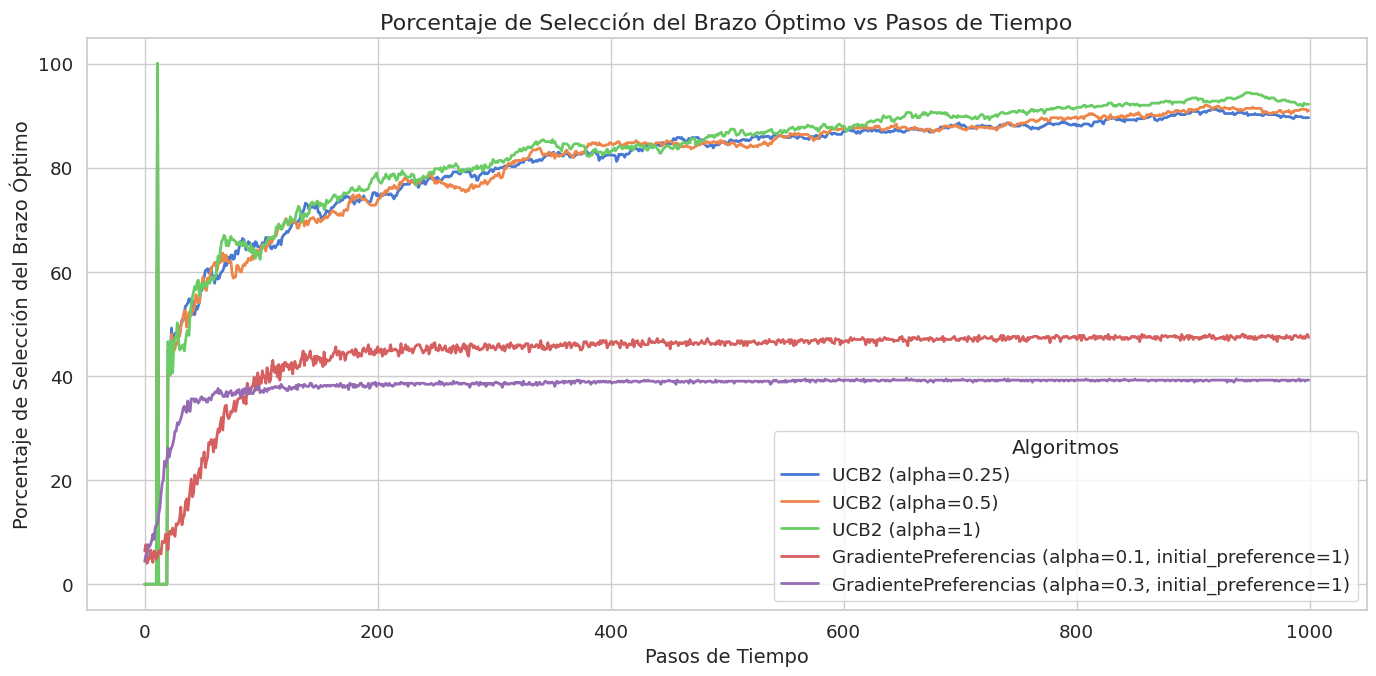

In [11]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos UCB2 y Gradiente de Preferencias con diferentes valores de parámetros.

**Observaciones principales**
1. **UCB2 (α = 0.25, 0.5, 1) - Líneas Azul, Naranja, Verde:**

  * Tardan pocas iteraciones en converger a un 90% de selección de brazo óptimo. Empeorando un 10% frente a 10 brazos.
  * Siguen sin verse diferencias significativas entre los valores de α en términos de selección del mejor brazo.

2. **Gradiente de Preferencias (α=0.1 y α=0.3) - Líneas Roja y Morada:**

  * Gradiente de Preferencias con α=0.3 (Morado):
    * Aprende más rápido que α=0.1, pero su selección del brazo óptimo se estabiliza alrededor del 30%.
  * Gradiente de Preferencias con α=0.1 (Rojo):
    * Aprende más lentamente que todas las demás estrategias.
    * Después de 100 pasos de tiempo, apenas llega al 50% de selección del brazo óptimo, con más variabilidad en su desempeño.
  
  * Ambas variantes empeoran bastante frente al ejemplo de 10 brazos.

**Conclusiones**
* UCB2 es la mejor estrategia para seleccionar consistentemente el brazo óptimo.
* Gradiente de Preferencias empeora casi a la mitad que con 10 brazos.

#### K = 30

In [12]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 30  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=1), GradientePreferencias(k=k, alpha=0.1), GradientePreferencias(k=k, alpha=0.3)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 30 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=2.91, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0), ArmNormal(mu=9.73, sigma=1.0), ArmNormal(mu=8.49, sigma=1.0), ArmNormal(mu=5.72, sigma=1.0), ArmNormal(mu=6.51, sigma=1.0), ArmNormal(mu=3.74, sigma=1.0), ArmNormal(mu=2.26, sigma=1.0), ArmNormal(mu=5.1, sigma=1.0), ArmNormal(mu=6.33, sigma=1.0), ArmNormal(mu=8.07, sigma=1.0), ArmNormal(mu=2.8, sigma=1.0), ArmNormal(mu=3.62, sigma=1.0), ArmNormal(mu=3.63, sigma=1.0), ArmNormal(mu=4.89, sigma=1.0), ArmNormal(mu=4.3, sigma=1.0), ArmNormal(mu=5.63, sigma=1.0), ArmNormal(mu=6.47, sigma=1.0), ArmNormal(mu=2.64, sigma=1.0), ArmNormal(mu=2.65, sigma=1.0), ArmNormal(mu=1.42, sigma=1.0)
Optimal arm: 12 with expected reward=9.73


##### Recompensa promedio

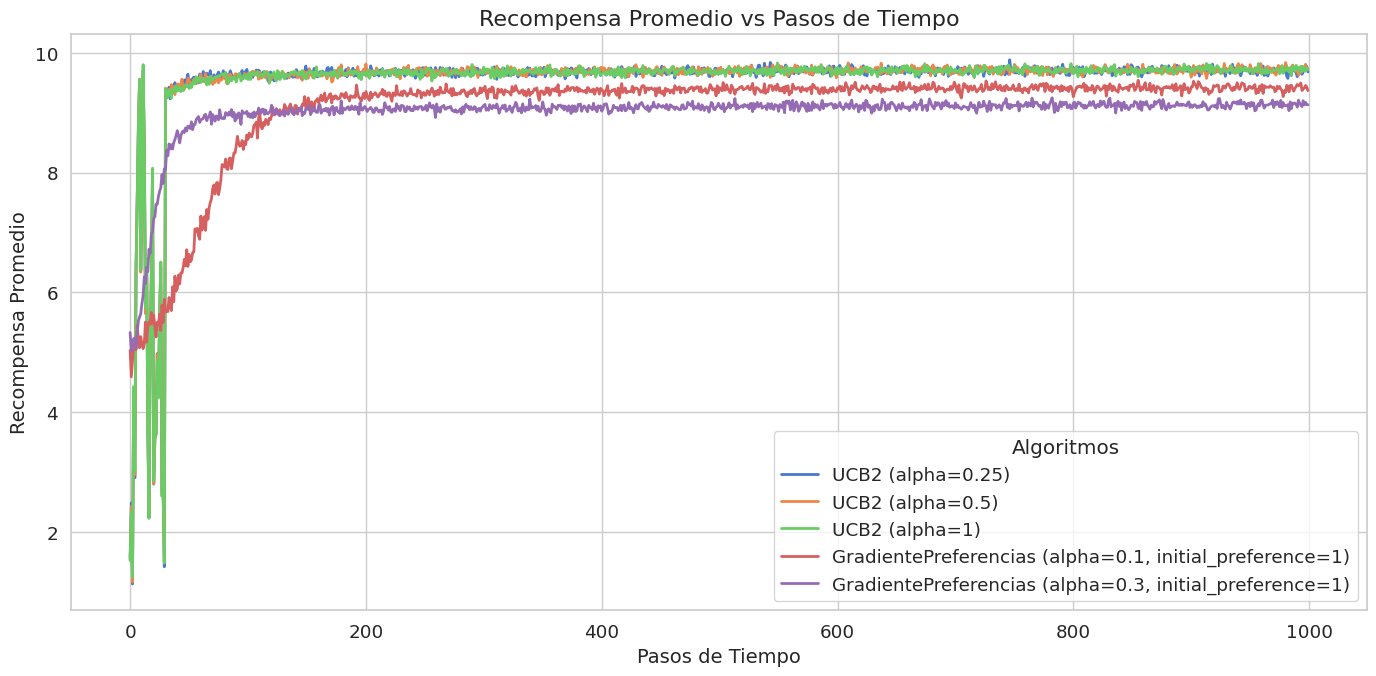

In [13]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos UCB2 y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
1. **UCB2 (α = 0.1, 0.25, 0.5, 1):**

  * Todas las variantes de UCB2 alcanzan rápidamente una recompensa promedio cercana a 10.
  * No hay diferencias significativas entre los valores de α, ya que todas convergen al mismo nivel de recompensa.
  * Presentan poca variabilidad y logran un buen resultados desde las primeras iteraciones. Aunque podemos observar que tarda unas decenas de iteraciones más en converger.

2. **Gradiente de Preferencias (α = 0.01 y α = 0.1):**
  * Tarda más en converger y obtiene peores resultados.
  * La línea marrón (α=0.1) aprende más rápido que la variante con α=0.01, alcanzando una recompensa promedio cercana a 9.5, algo inferior a la óptima.
  * La línea morada (α=0.01) muestra un crecimiento bastante más lento.
  * Al final de la simulación, aún no ha alcanzado el nivel de las otras estrategias.

**Conclusiones**
  * Vemos que los dos algoritmos empeoran levemente frente al escenario de 20 brazos. No hay tanta diferencia como la que encontramos en el escenario de 10 a 20.

##### Regret acumulado

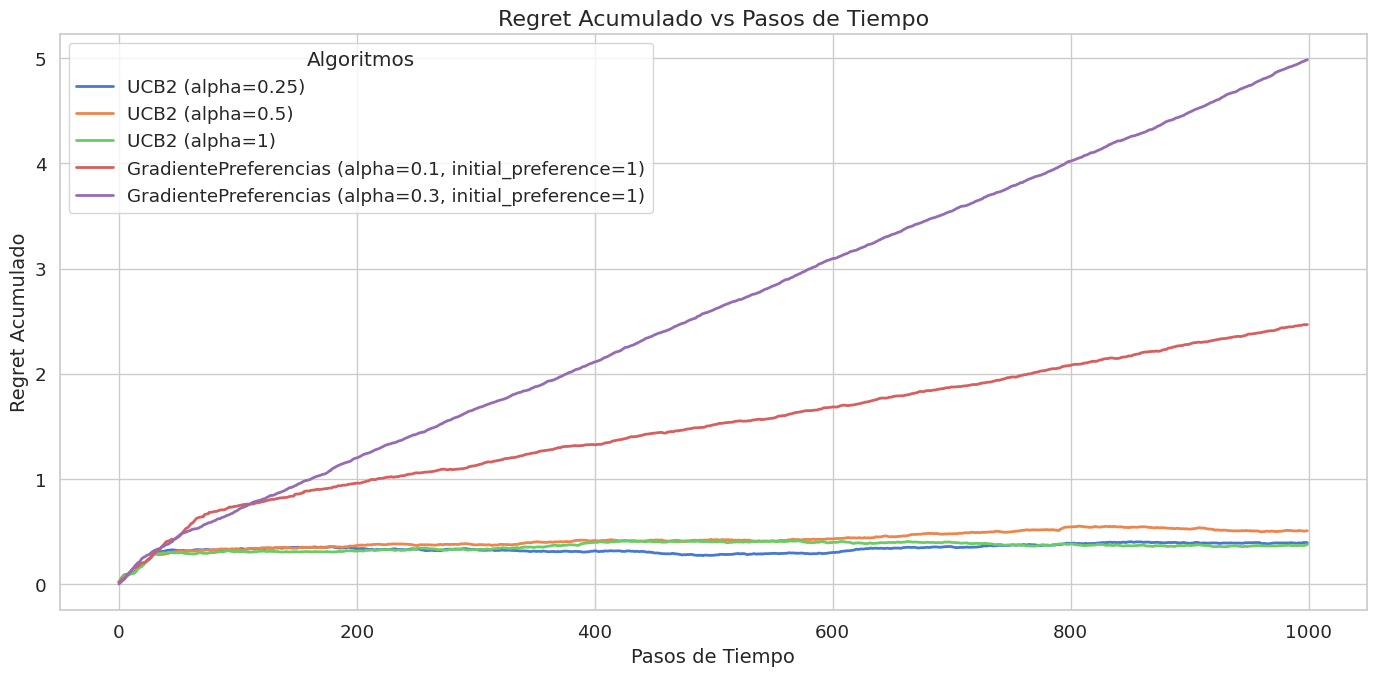

In [14]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos UCB2 y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
  * Todos las variantes de UCB2 obtienen un resultado muy bueno. Siendo la mejor la que tiene alpha=0.25, aunque puede deberse a la varianza.
  * Las variante de Gradiente de Preferencias obtiene resultados bastante malos.

**Conclusiones**
  * Mucha diferencia frente al gráfico inicial. El regret de Gradiente de Preferencias aumenta mucho frente al de UCB2.

##### Porcentaje de selección del brazo óptimo

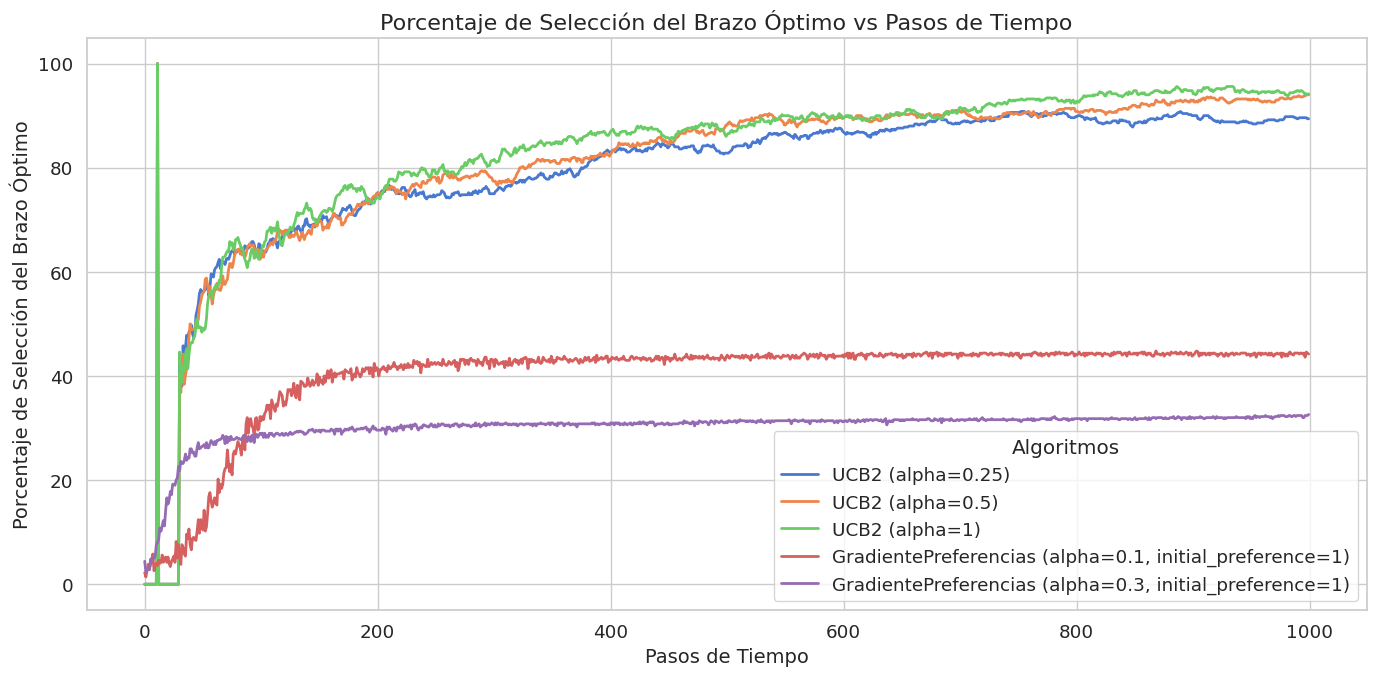

In [15]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos UCB2 y Gradiente de Preferencias con diferentes valores de parámetros.

**Observaciones principales**
1. **UCB2 (α = 0.1, 0.25, 0.5, 1) - Líneas Azul, Naranja, Verde:**

  * Tardan algo más en alcanzar el 95% de selección del brazo óptimo.

2. **Gradiente de Preferencias (α=0.01 y α=0.1) - Líneas Morada y Marrón:**

  * Aquí si podemos apreciar diferencias significativas. El porcentaje de selección del brazo óptimo ha bajado bastante con respecto a el escenario original y el anterior.

**Conclusiones**
* UCB2 es la mejor estrategia para seleccionar consistentemente el brazo óptimo.
* Gradiente de Preferencias, las dos variantes, obtienen resultados bastante deficientes.

## Comparación entre distribuciones
El paso final es analizar su comportamiento ante diferentes distribuciones de recompensa.

No se va a analizar la distribución normal ya que saldrían las mismas graficas que obtenidas en el apartado "Comparación entre algoritmos".

#### Distribución binomial

In [16]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k, 10)) # Generar un bandido con k brazos de distribución binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=1), GradientePreferencias(k=k, alpha=0.1), GradientePreferencias(k=k, alpha=0.3)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(n=10, p=0.4), ArmBinomial(n=10, p=0.86), ArmBinomial(n=10, p=0.22), ArmBinomial(n=10, p=0.69), ArmBinomial(n=10, p=0.58), ArmBinomial(n=10, p=0.15), ArmBinomial(n=10, p=0.79), ArmBinomial(n=10, p=0.67), ArmBinomial(n=10, p=0.12), ArmBinomial(n=10, p=0.88)
Optimal arm: 10 with expected reward=8.8


##### Recompensa promedio

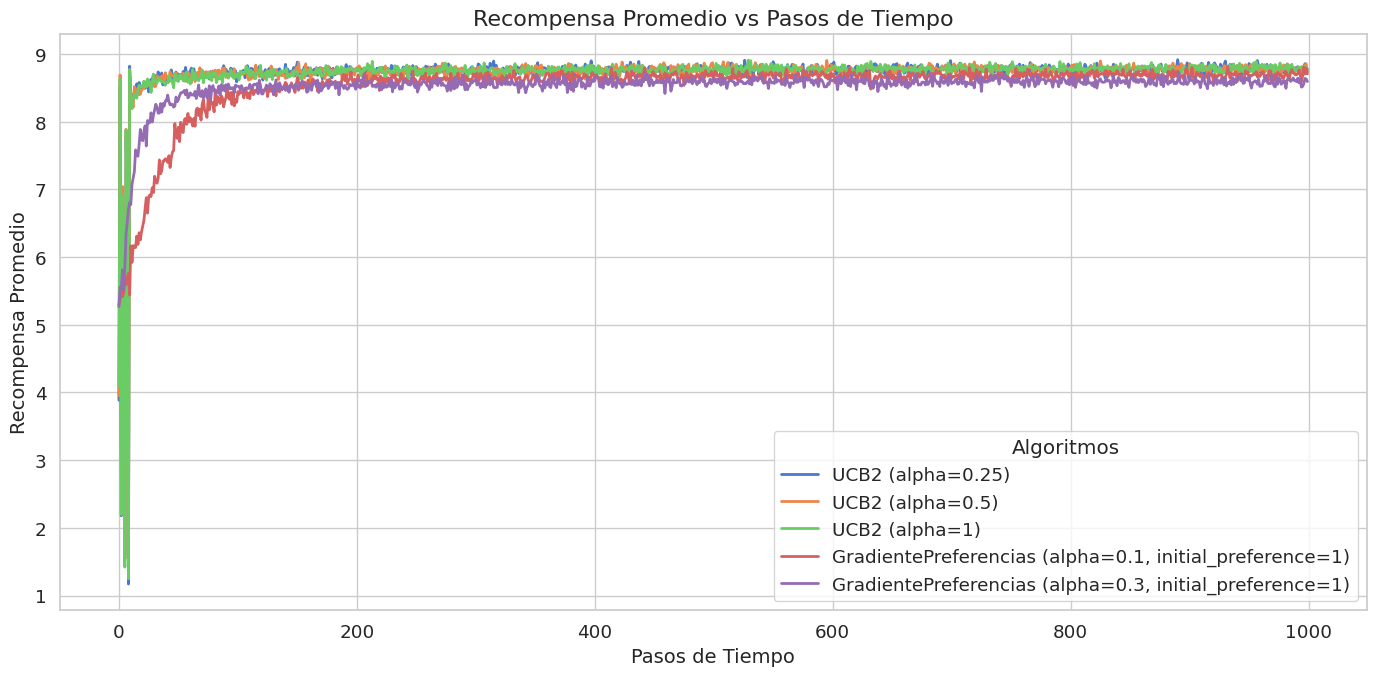

In [17]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos UCB2 y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
1. **UCB2 (α = 0.1, 0.25, 0.5, 1):**

  * Estas curvas (en azul, naranja, verde y rojo) tienden a converger a una recompensa promedio cercana a 9 con pequeñas fluctuaciones.
  * La variación de α no afecta la rapidez con la que alcanzan la recompensa óptima. A simple vista no se puede diferenciar cual llega antes.

2. **Gradiente de Preferencias (α = 0.1 y α = 0.3):**

  * Igual que la distribución normal, pero con más iteraciones para converger.

**Conclusiones**
  * Los resultados que obtenemos con la distribución binomial, son bastante similares a los que obtenemos con la distribución normal y aumentamos el número de brazos.

##### Regret acumulado

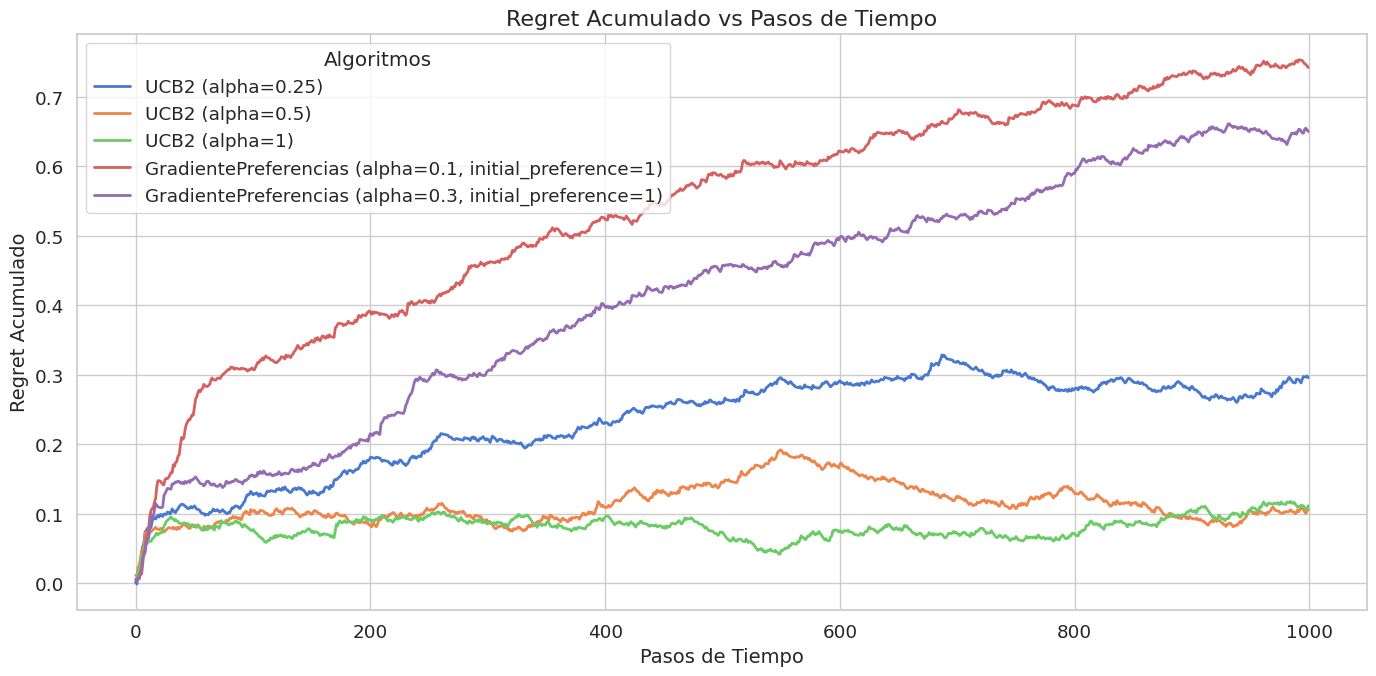

In [18]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos UCB2 y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
* Aquí vemos un comportamiento similar al de la distribución normal con 10 brazos. Donde todos obtienen un regret acumulado similar, algo inferior para las variatnes de Gradiente de Preferencias.

**Conclusiones**
  * UCB2 tiene un buen desempeño, obteniendo regret bajo.

##### Porcentaje de selección del brazo óptimo

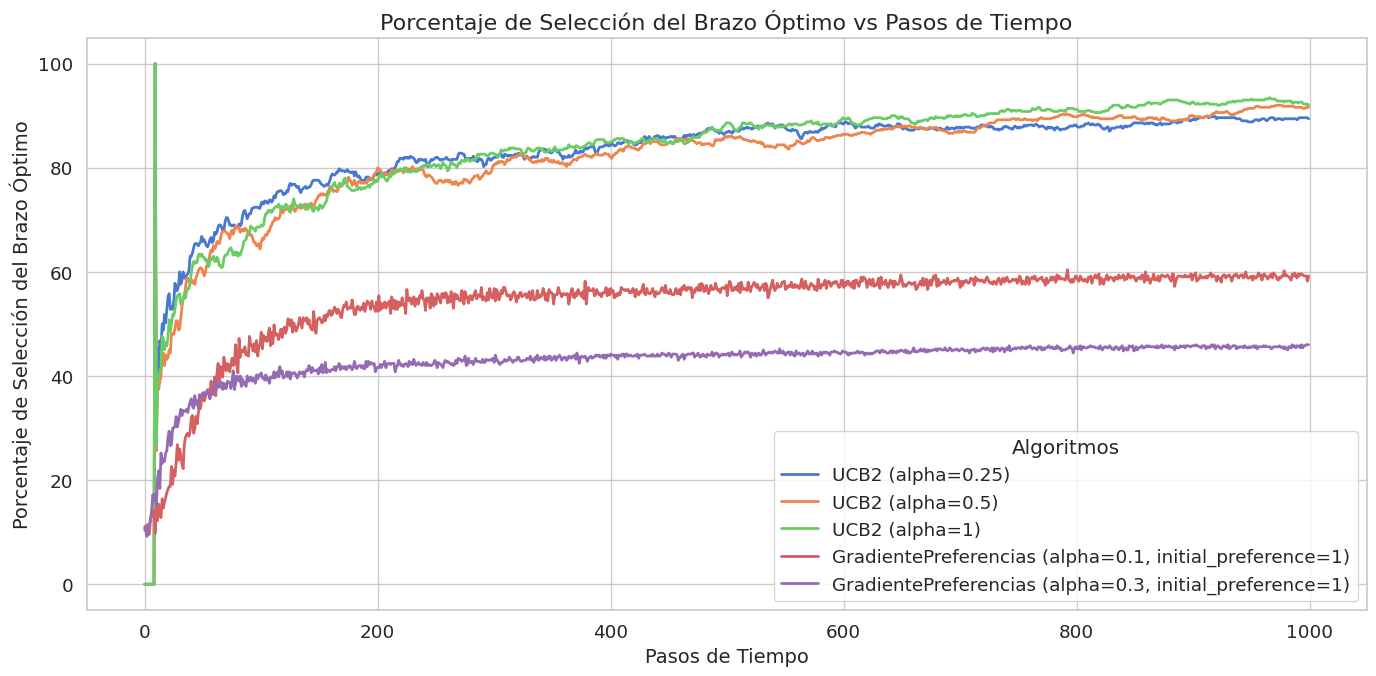

In [19]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos UCB2 y Gradiente de Preferencias con diferentes valores de parámetros.

**Observaciones principales**
* Volvemos a obtener una gráfica paracida a cuando aumentamos el número de brazos.
* Aquí Gradiente de Preferencias obtiene mejores resultados un 5-10% más que con 20 brazos.

**Conclusiones**
* UCB2 es la mejor estrategia para seleccionar consistentemente el brazo óptimo.
* Gradiente de Preferencias obtiene unos resultados bastante malos.
* El resultado es bastante similar al que obtenemos con más brazos.

#### Distribución de Bernoulli

In [20]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=1), GradientePreferencias(k=k, alpha=0.1), GradientePreferencias(k=k, alpha=0.3)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.4), ArmBernoulli(p=0.86), ArmBernoulli(p=0.22), ArmBernoulli(p=0.69), ArmBernoulli(p=0.58), ArmBernoulli(p=0.15), ArmBernoulli(p=0.79), ArmBernoulli(p=0.67), ArmBernoulli(p=0.12), ArmBernoulli(p=0.88)
Optimal arm: 10 with expected reward=0.88


##### Recompensa promedio

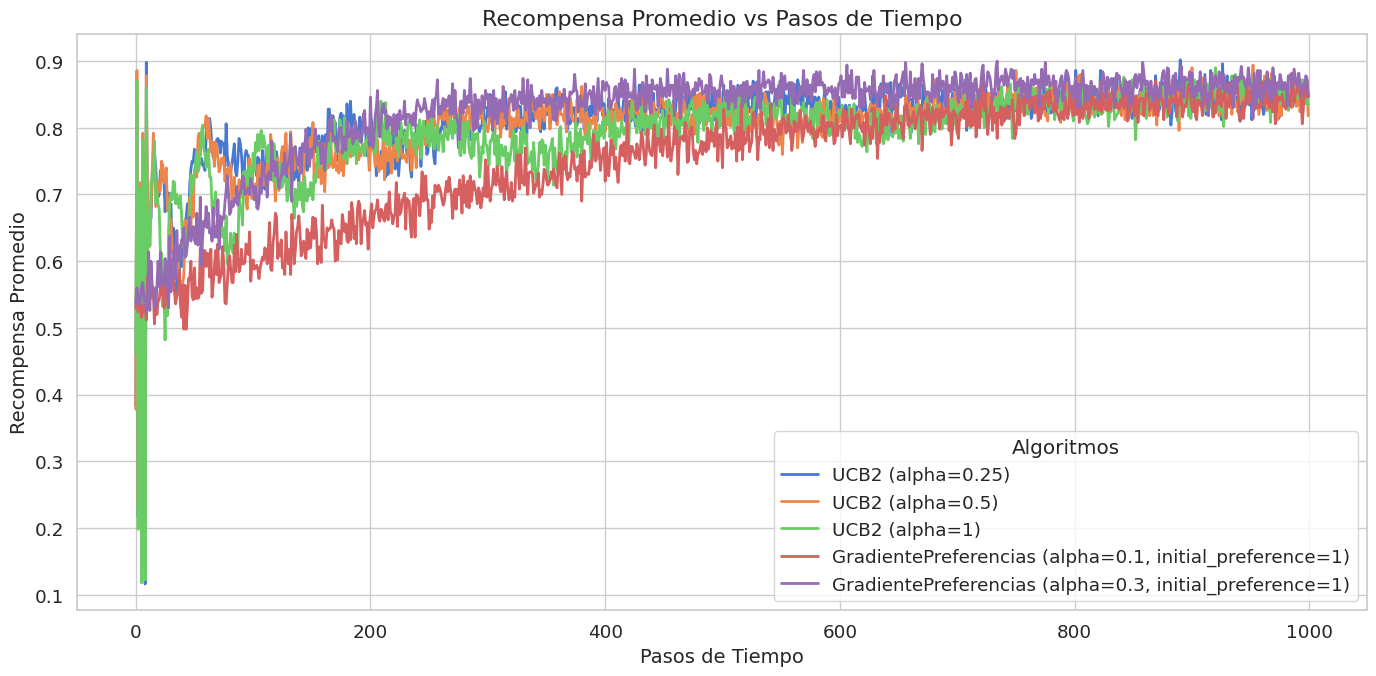

In [21]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "**Recompensa Promedio vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos UCB2 y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
  * Todas las variantes al llegar a los 1000 pasos de tiempo obtiene la misma recompensa promedio.
  * Siendo las variantes de Gradiente de Preferencias las más estables.
  * Se observa muchas irregularidades al inicio con UCB2.

**Conclusiones**
  * Parece que con la distribución de Bernoulli, Gradiente de Preferencias funciona bastante bien.

##### Regret acumulado

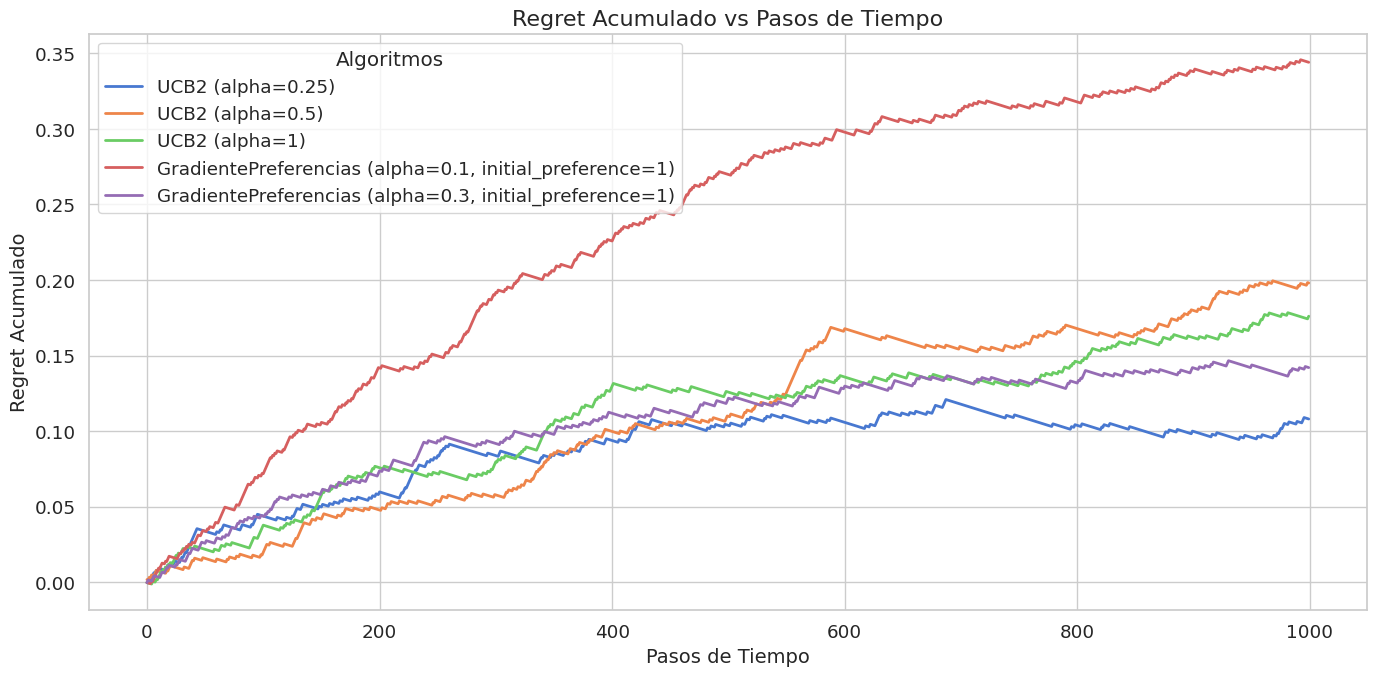

In [22]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "**Regret Acumulado vs Pasos de Tiempo**", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Regret Acumulado" → Muestra el regret acumulado a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos UCB2 y Gradiente de Preferencias con diferentes valores de parámetros.

**Análisis del comportamiento**
* Podemos observar como el regret acumulado es muy similar para todas las variantes. Además, es bastante bajo.
* La variante de Gradiente de Preferencias con alpha=0.3 obtiene un regret acumulado similar a UCB2.

**Conclusiones**
  * UCB2 tiene un buen desempeño, obteniendo regret bajo. Las 3 variantes tienen practicamente el mismo regret acumulado.

##### Porcentaje de selección del brazo óptimo

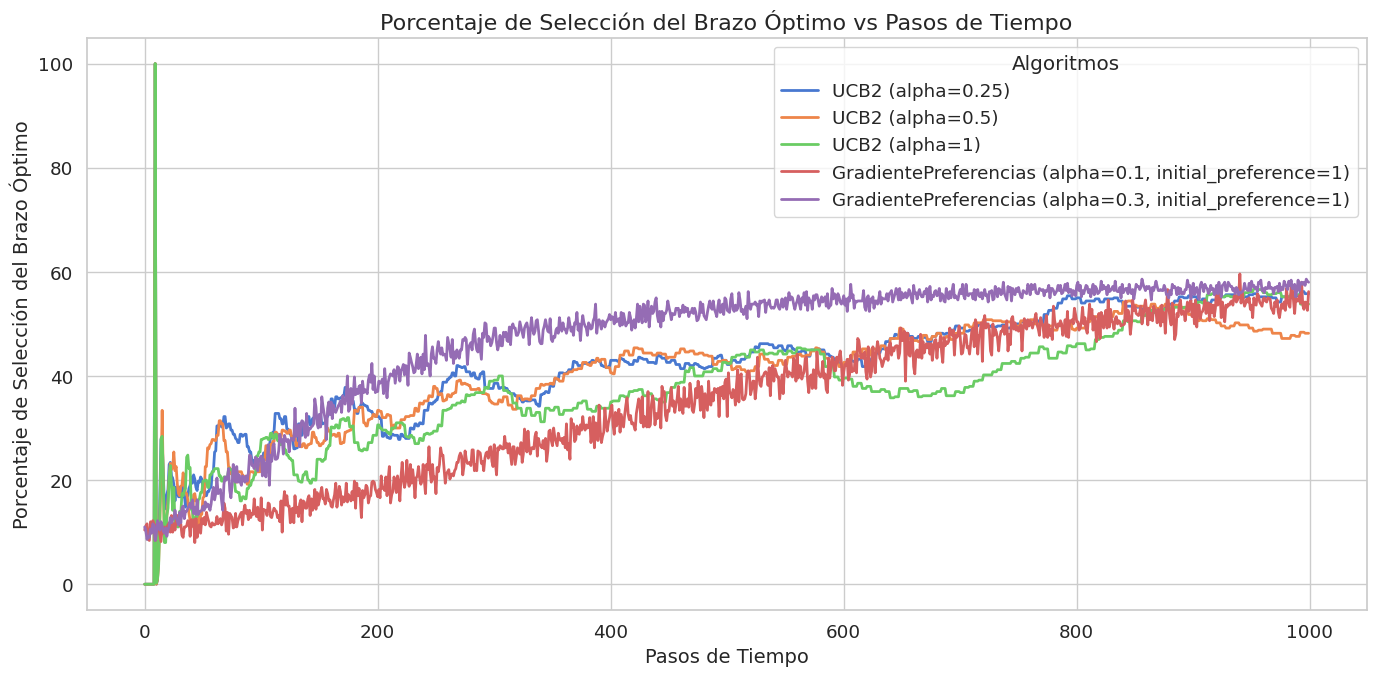

In [23]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintas variantes de los algoritmos UCB2 y Gradiente de Preferencias con diferentes valores de parámetros.

**Observaciones principales**
* Todos obtienen un porcentaje de selección del brazo óptimo similar al final de la ejecución.
* La variante de Gradiente de Preferencias con alpha=0.1 tarda bastante en converger.
* La mejor variante es de Gradiente de Preferencias con alpha=0.3.

**Conclusiones**
* UCB2 es obtiene resultados muy buenos con todas las distribuciones. En este caso, está en medio de las dos variantes de Gradiente de Preferencias.
* Gradiente de Preferencias con α=0.3 obtiene unos resultados bastante buenos.